In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import matplotlib.colors as clr
%matplotlib inline

def degreesToRadians(degrees):
  return degrees * math.pi / 180

def distanceInKmBetweenEarthCoordinates(pos1, pos2):
  earthRadiusKm = 6371
  dLon = degreesToRadians(pos2[1]-pos1[1])
  dLat = degreesToRadians(pos2[0]-pos1[0])

  lat1 = degreesToRadians(pos1[0])
  lat2 = degreesToRadians(pos2[0])

  a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2); 
  c = 2 * math.asin(math.sqrt(a)); 
  return earthRadiusKm * c

def calcular_distancia_euclidean(cord1,cord2):
    return math.sqrt((cord1[0]-cord2[0])**2 +(cord1[1]-cord2[1])**2+(cord1[2]-cord2[2])**2) #Calcular la distancia entre dos puntos con coordenadas cartesianas x,y,z


df = pd.read_json('coordenadas_con_centros.json')

for k in range(3,11):
    cl = len(list(df['cluster_%d' %k].unique()))
    hospital_principal=[]
    for i in range(cl):
        dsc = df.loc[df['cluster_%d' %k] == i]
        dsc = dsc[["id","centers_%d" %k,"cartesianas"]]
        distancia_minima=100
        hospital_centro = 0
        for index, row in dsc.iterrows():
            distancia = calcular_distancia_euclidean(row["cartesianas"],row["centers_%d" %k])
            if distancia_minima > distancia:
                distancia_minima = distancia
                hospital_centro=row["id"]
        hospital_principal.append(hospital_centro)

    hospitales_centros = []
    for p in range(0,len(df)):
        hospitales_centros.append(hospital_principal[df["cluster_%d" %k][p]])    
    df['hospitales_centros_%d' %k] = hospitales_centros
df.to_json("coordenadas_hospitales_centroides.json")


for k in range(3,11):
    coordenadas_centro = []
    nd = {}
    nd["inicio_%d" %k] = []
    nd["final_%d" %k] = []
    nd["distancias_%d" %k] = []
    nd["cordenada_inicio_%d" %k] = []
    nd["cordenada_final_%d" %k] = []
    nd["gps_inicio_%d" %k] = []
    nd["gps_final_%d" %k] = []
    for cord in df["hospitales_centros_%d" %k]:
        coordenadas_centro.append([df["latitud"][cord],df["longitud"][cord]])
    df["Coordenada_hospital_centro_%d" %k] = coordenadas_centro

    coordenadas_centro_cartesianas = []
    for cord in df["hospitales_centros_%d" %k]:
        coordenadas_centro_cartesianas.append(df["cartesianas"][cord])
    df["Coordenada_hospital_centro_cartesiana_%d" %k] = coordenadas_centro_cartesianas


    coordenadas_hospital = []
    for index, row in df.iterrows():
        coordenadas_hospital.append([row["latitud"],row["longitud"]])
    df["Coordenada_hospital_%d" %k] = coordenadas_hospital

    distancias_hospital_centro = []
    for index, row in df.iterrows():
        distancias_hospital_centro.append(distanceInKmBetweenEarthCoordinates(row["Coordenada_hospital_centro_%d" %k],row["Coordenada_hospital_%d" %k]))
    df["distancia_centro_%d" %k] = distancias_hospital_centro

    cl = list(df['hospitales_centros_%d' %k].unique())

    for i in range(0,len(cl)):
        for j in range(i+1,len(cl)):
            nd["inicio_%d" %k].append(cl[i])
            nd["final_%d" %k].append(cl[j])
            nd["gps_inicio_%d" %k].append([df["latitud"][cl[i]],df["longitud"][cl[i]]])
            nd["gps_final_%d" %k].append([df["latitud"][cl[j]],df["longitud"][cl[j]]])
            nd["cordenada_inicio_%d" %k].append(df["cartesianas"][cl[i]])
            nd["cordenada_final_%d" %k].append(df["cartesianas"][cl[j]])
            nd["distancias_%d" %k].append(distanceInKmBetweenEarthCoordinates(df["Coordenada_hospital_%d" %k][cl[i]],df["Coordenada_hospital_%d" %k][cl[j]]))
    cdf = pd.DataFrame.from_dict(nd)
    cdf.to_json("centroides_final_%d.json" %k)
df.to_json("hospitales_data_final.json")


['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']


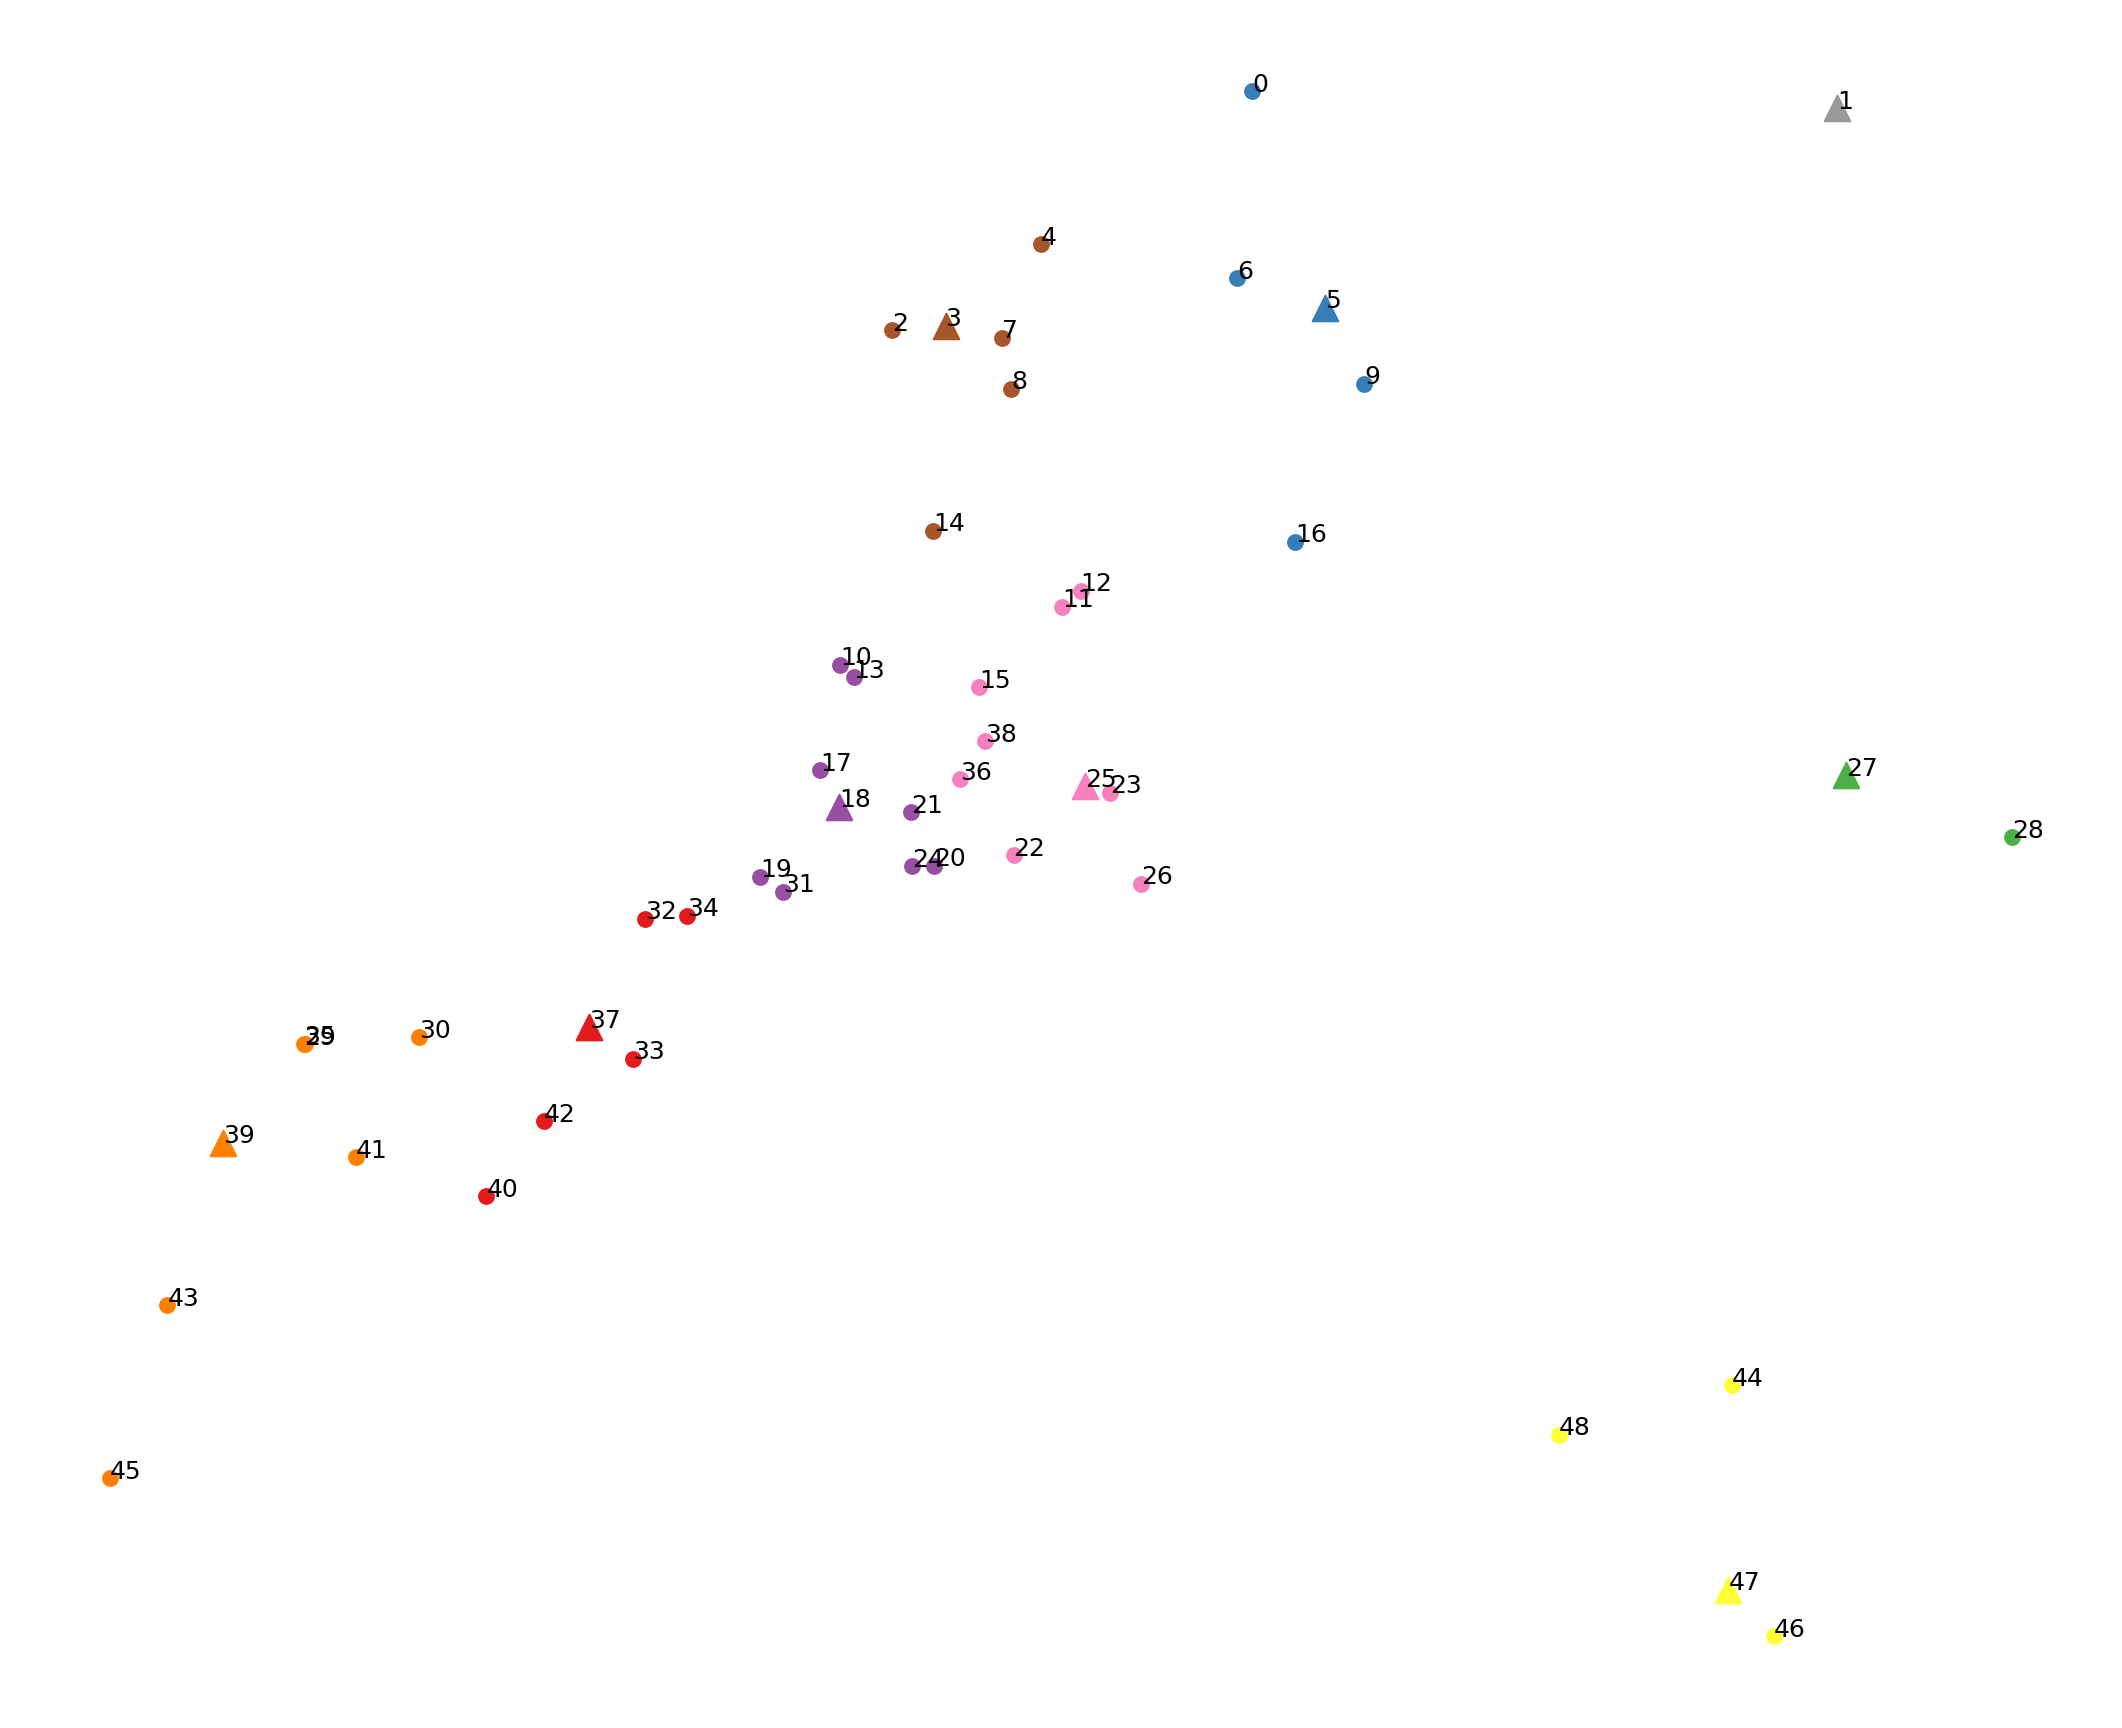

In [8]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [18,15]
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.axis('off')
plt.grid(False)
#0->x, 1->y, 2->z
v = 0
q = 1

colors = cm.Set1(np.linspace(0, 1, 9))
arreglo_de_colores = []
for color in colors:
    arreglo_de_colores.append(clr.rgb2hex(color))
print(arreglo_de_colores)
for nc in range(len(cl)):   
    g = df.loc[(df["cluster"] == nc) & (df["distancia_centro"] != 0.0)]   
    x = [i[v] for i in g['cartesianas']]
    y = [i[q] for i in g['cartesianas']]
    number = [i for i in g['id']]
    for a in range(len(x)):
        plt.text(x[a],y[a], '%d' %number[a] , fontsize=12)
    plt.scatter(x,y , color=colors[nc],marker = 'o', zorder=2, alpha=1.0, s=50)
for nc in cl:   
    x = df["Coordenada_hospital_centro_cartesiana"][nc][v]
    y = df["Coordenada_hospital_centro_cartesiana"][nc][q]
    plt.scatter(x,y , color=colors[df["cluster"][nc]],marker = '^',  s=150)
    plt.text(x,y, '%d'%nc, fontsize=12)

    

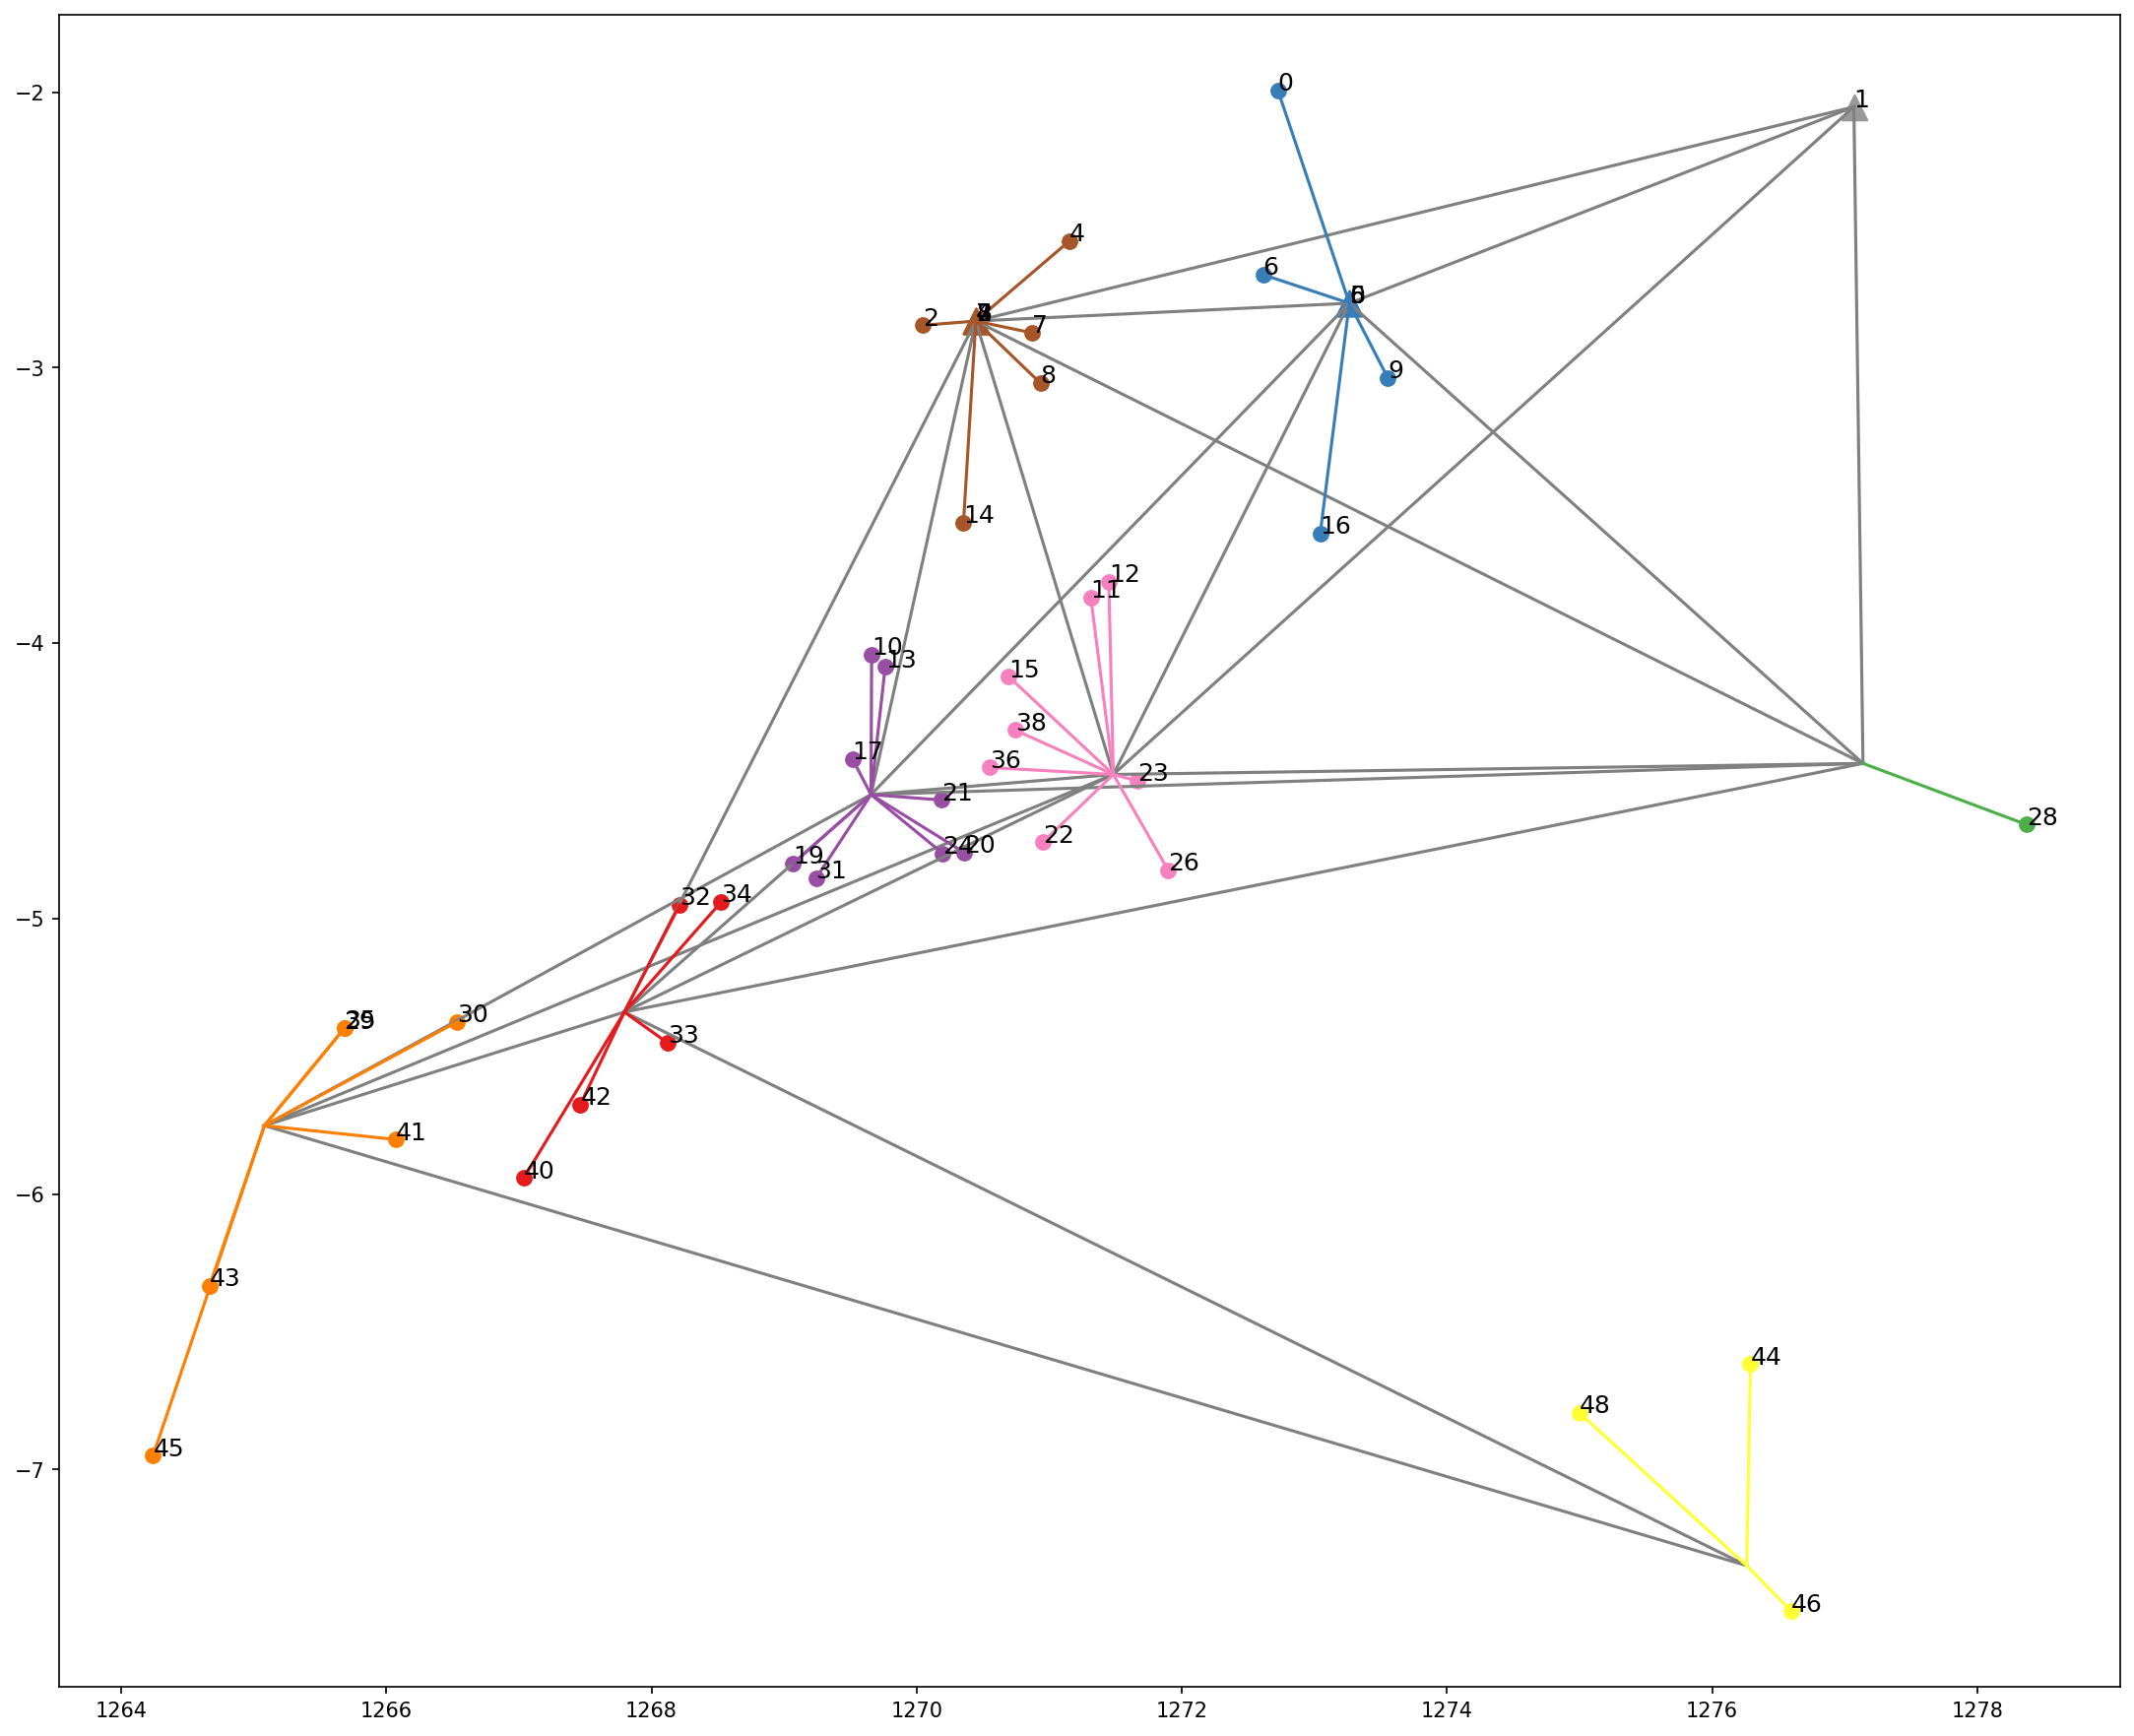

In [28]:
maxima_distancia = 14
#x = [i[v] for i in g['cartesianas']]
#print(g['cartesianas'])
#x = max(x)

#x = 1
#plt.xlim(x-12, x+45)
for nc in range(len(cl)):   
    g = df.loc[(df["cluster"] == nc) & (df["distancia_centro"] !=0)]   
    x = [i[v] for i in g['cartesianas']]
    y = [i[q] for i in g['cartesianas']]
    number = [i for i in g['id']]
    for a in range(len(x)):
        plt.text(x[a],y[a], '%d' %number[a] , fontsize=12)
    plt.scatter(x,y , color=colors[nc],marker = 'o', zorder=2, alpha=1.0, s=50)

for nc in range(len(cl)):   
    x = df["Coordenada_hospital_centro_cartesiana"][cl[nc]][v]
    y = df["Coordenada_hospital_centro_cartesiana"][cl[nc]][q]
    plt.scatter(x,y , color=colors[df["cluster"][cl[nc]]],marker = '^',  s=150)
    plt.text(x,y, '%d'%cl[nc], fontsize=12)

for index, row in cdf.iterrows():
    if row["distancias"] < maxima_distancia:
        plt.plot([row["cordenada_inicio"][v],row["cordenada_final"][v]],[row["cordenada_inicio"][q],row["cordenada_final"][q]],color="gray")
    

for nc in range(len(cl)):   
    g = df.loc[df['cluster'] == nc ]   
    x1 = [i[v] for i in g['cartesianas']]
    y1 = [i[q] for i in g['cartesianas']]
    x2 = [i[v] for i in g['Coordenada_hospital_centro_cartesiana']]
    y2 = [i[q] for i in g['Coordenada_hospital_centro_cartesiana']]
    for x_1,y_1,x_2,y_2 in zip(x1,y1,x2,y2):
        plt.plot([x_1,x_2],[y_1,y_2],color=colors[nc])


In [19]:
import networkx as nx

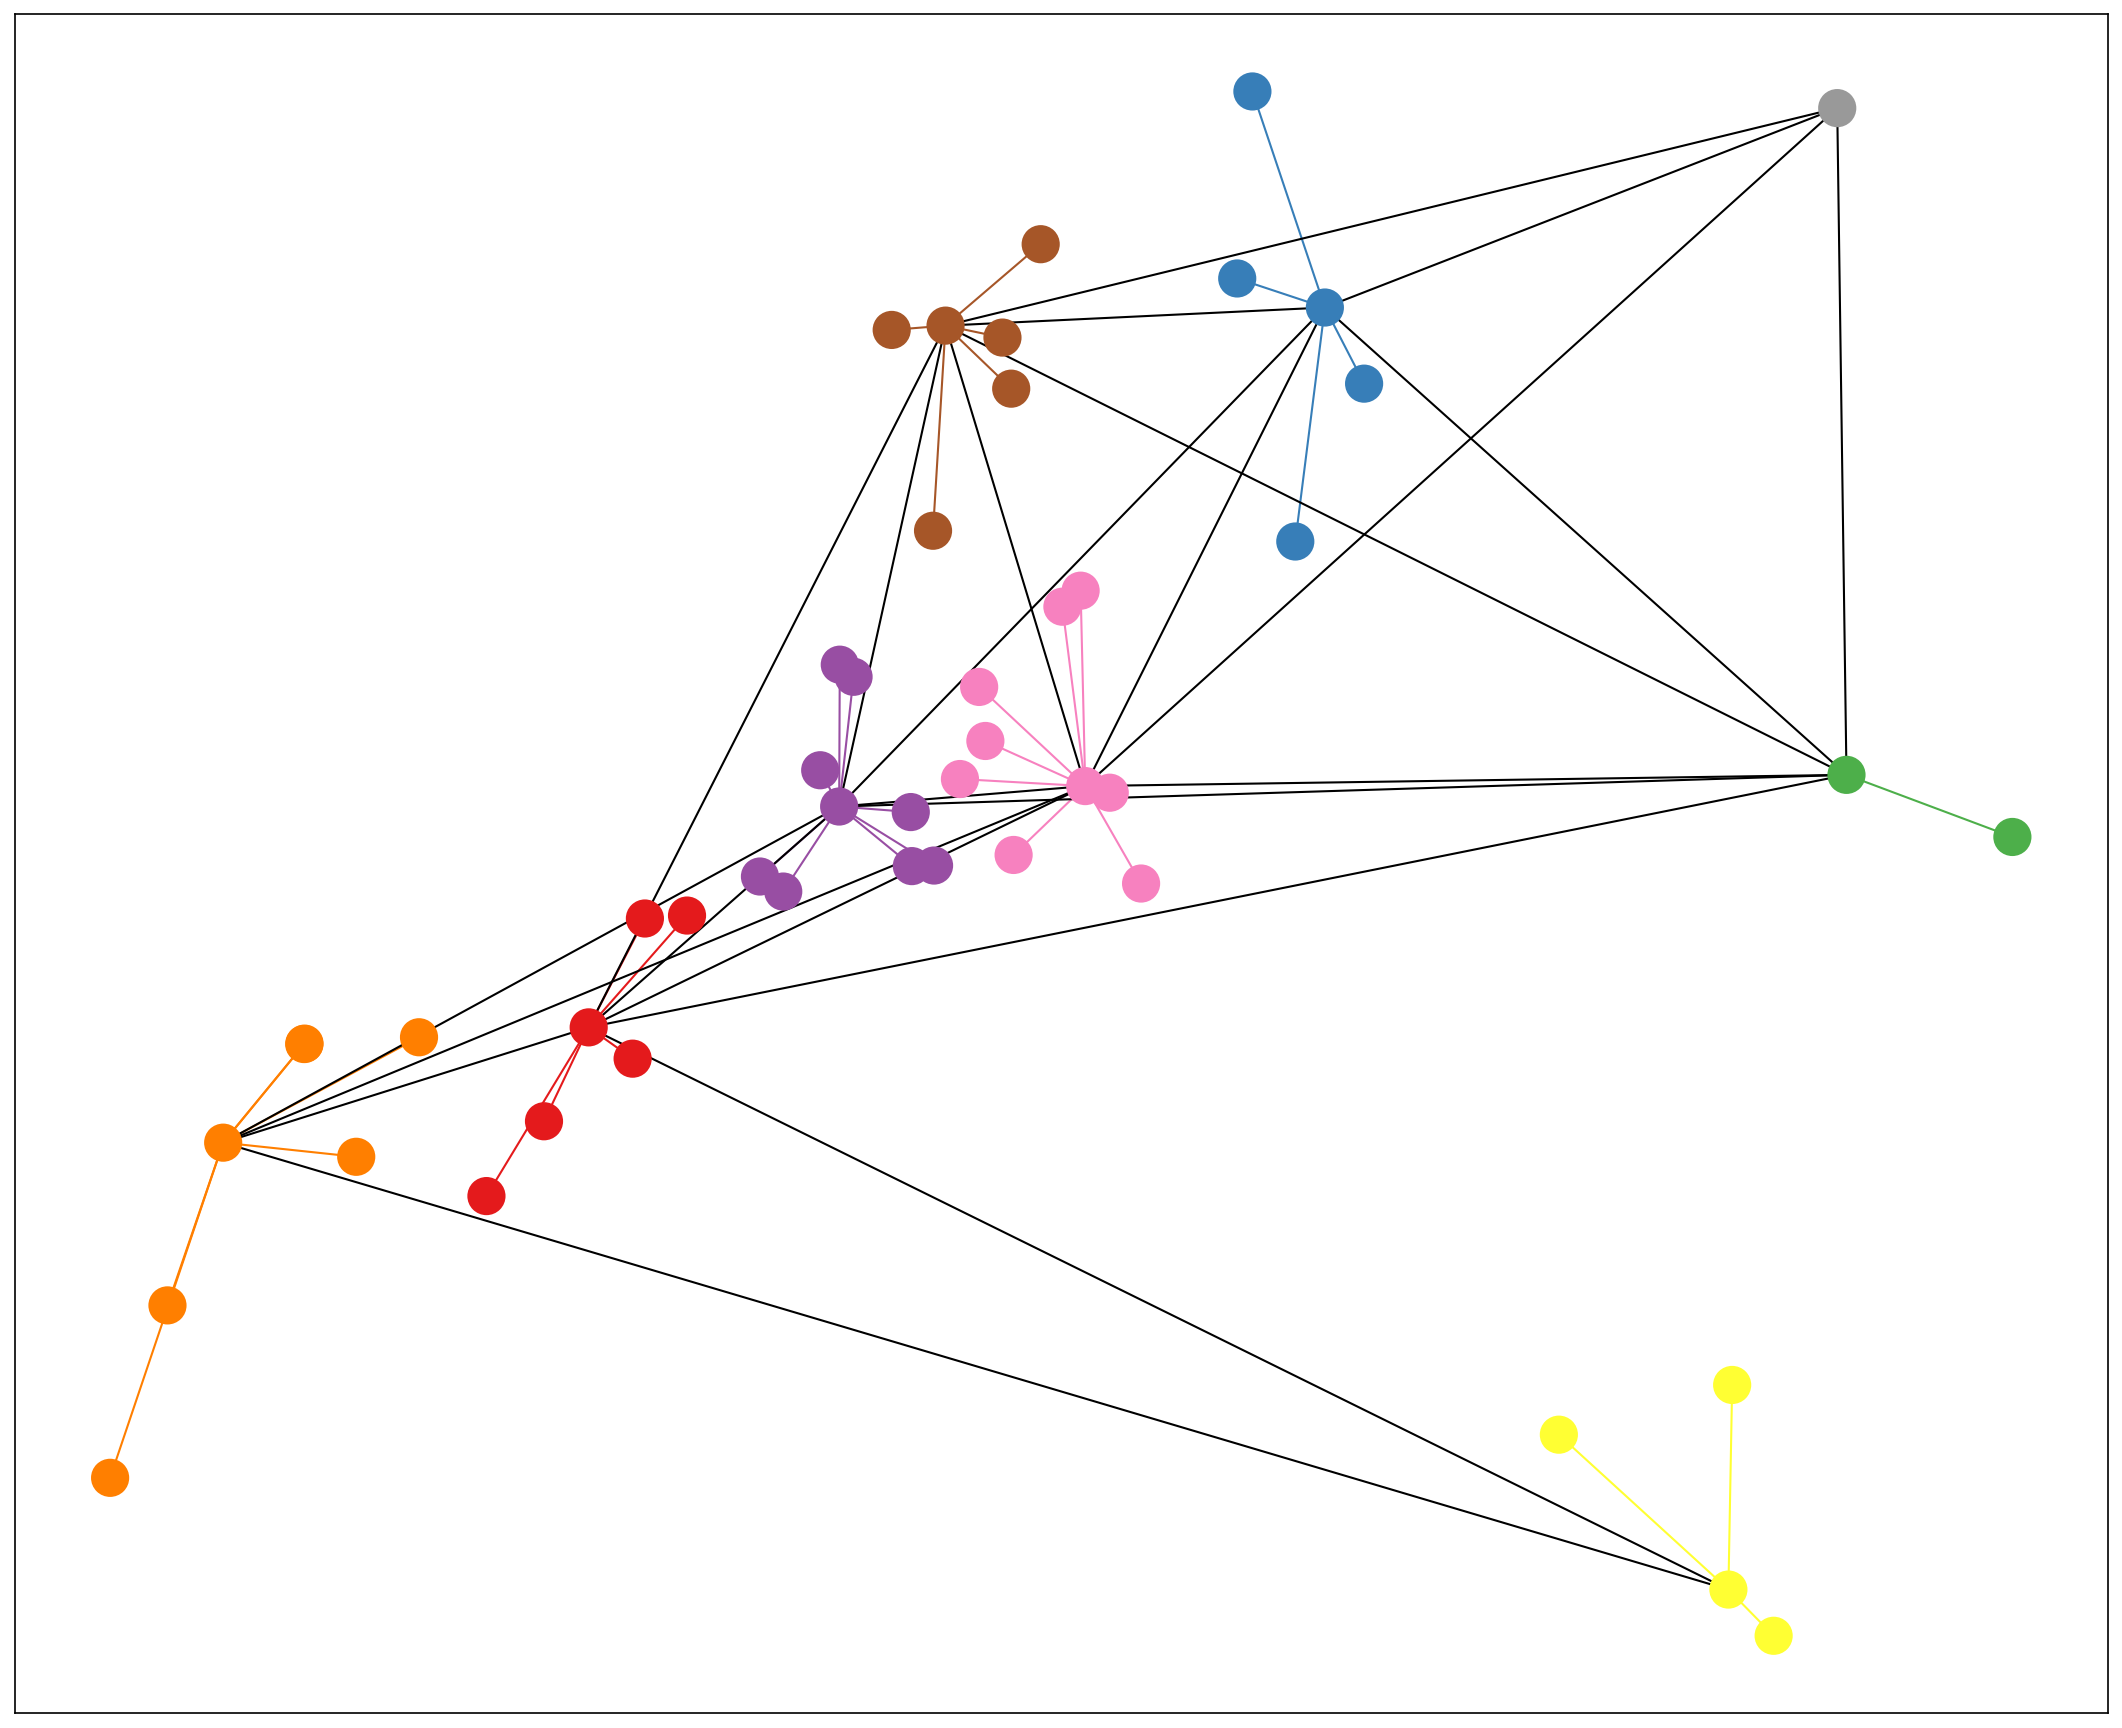

In [23]:
G = nx.Graph()

pos = {}
nodes = []
color_nodes = []
edges = []
distancias_nodos = []



for index, row in df.iterrows():
    G.add_node(row["id"])
    nodes.append(row["id"])
    pos[row["id"]] = (row["cartesianas"][0],row["cartesianas"][1])
    color_nodes.append(colors[row["cluster"]])
    edges.append((row["hospitales_centros"],row["id"]))
    distancias_nodos.append(row["distancia_centro"])

edges_path = []
distancias_centros = []
center_pos = {}
nx.draw_networkx_nodes(G,pos=pos,node_color=color_nodes)

for index, row in cdf.iterrows():
    if row["distancias"] < maxima_distancia:
        edges.append((row["inicio"],row["final"]))
        color_nodes.append([0,0,0,1])
        nf = cdf.loc[(cdf["inicio"] == row["inicio"]) & (cdf["final"] == row["final"]) ]
        for ind, r in nf.iterrows():
            distancias_centros.append(r["distancias"])

nx.draw_networkx_edges(G, pos=pos, edgelist=edges,edge_color=color_nodes)


[[ 0.          3.89977352  9.19289578 ... 27.43490841 32.03606826
  34.17017535]
 [ 3.89977352  0.          5.29312226 ... 23.53513489 28.13629474
  30.27040183]
 [ 9.19289578  5.29312226  0.         ... 28.8058234  33.2372787
  35.37138579]
 ...
 [27.43490841 23.53513489 28.8058234  ...  0.         20.78372441
  22.91783151]
 [32.03606826 28.13629474 33.2372787  ... 20.78372441  0.
   3.90360777]
 [34.17017535 30.27040183 35.37138579 ... 22.91783151  3.90360777
   0.        ]]
[[1]]
0


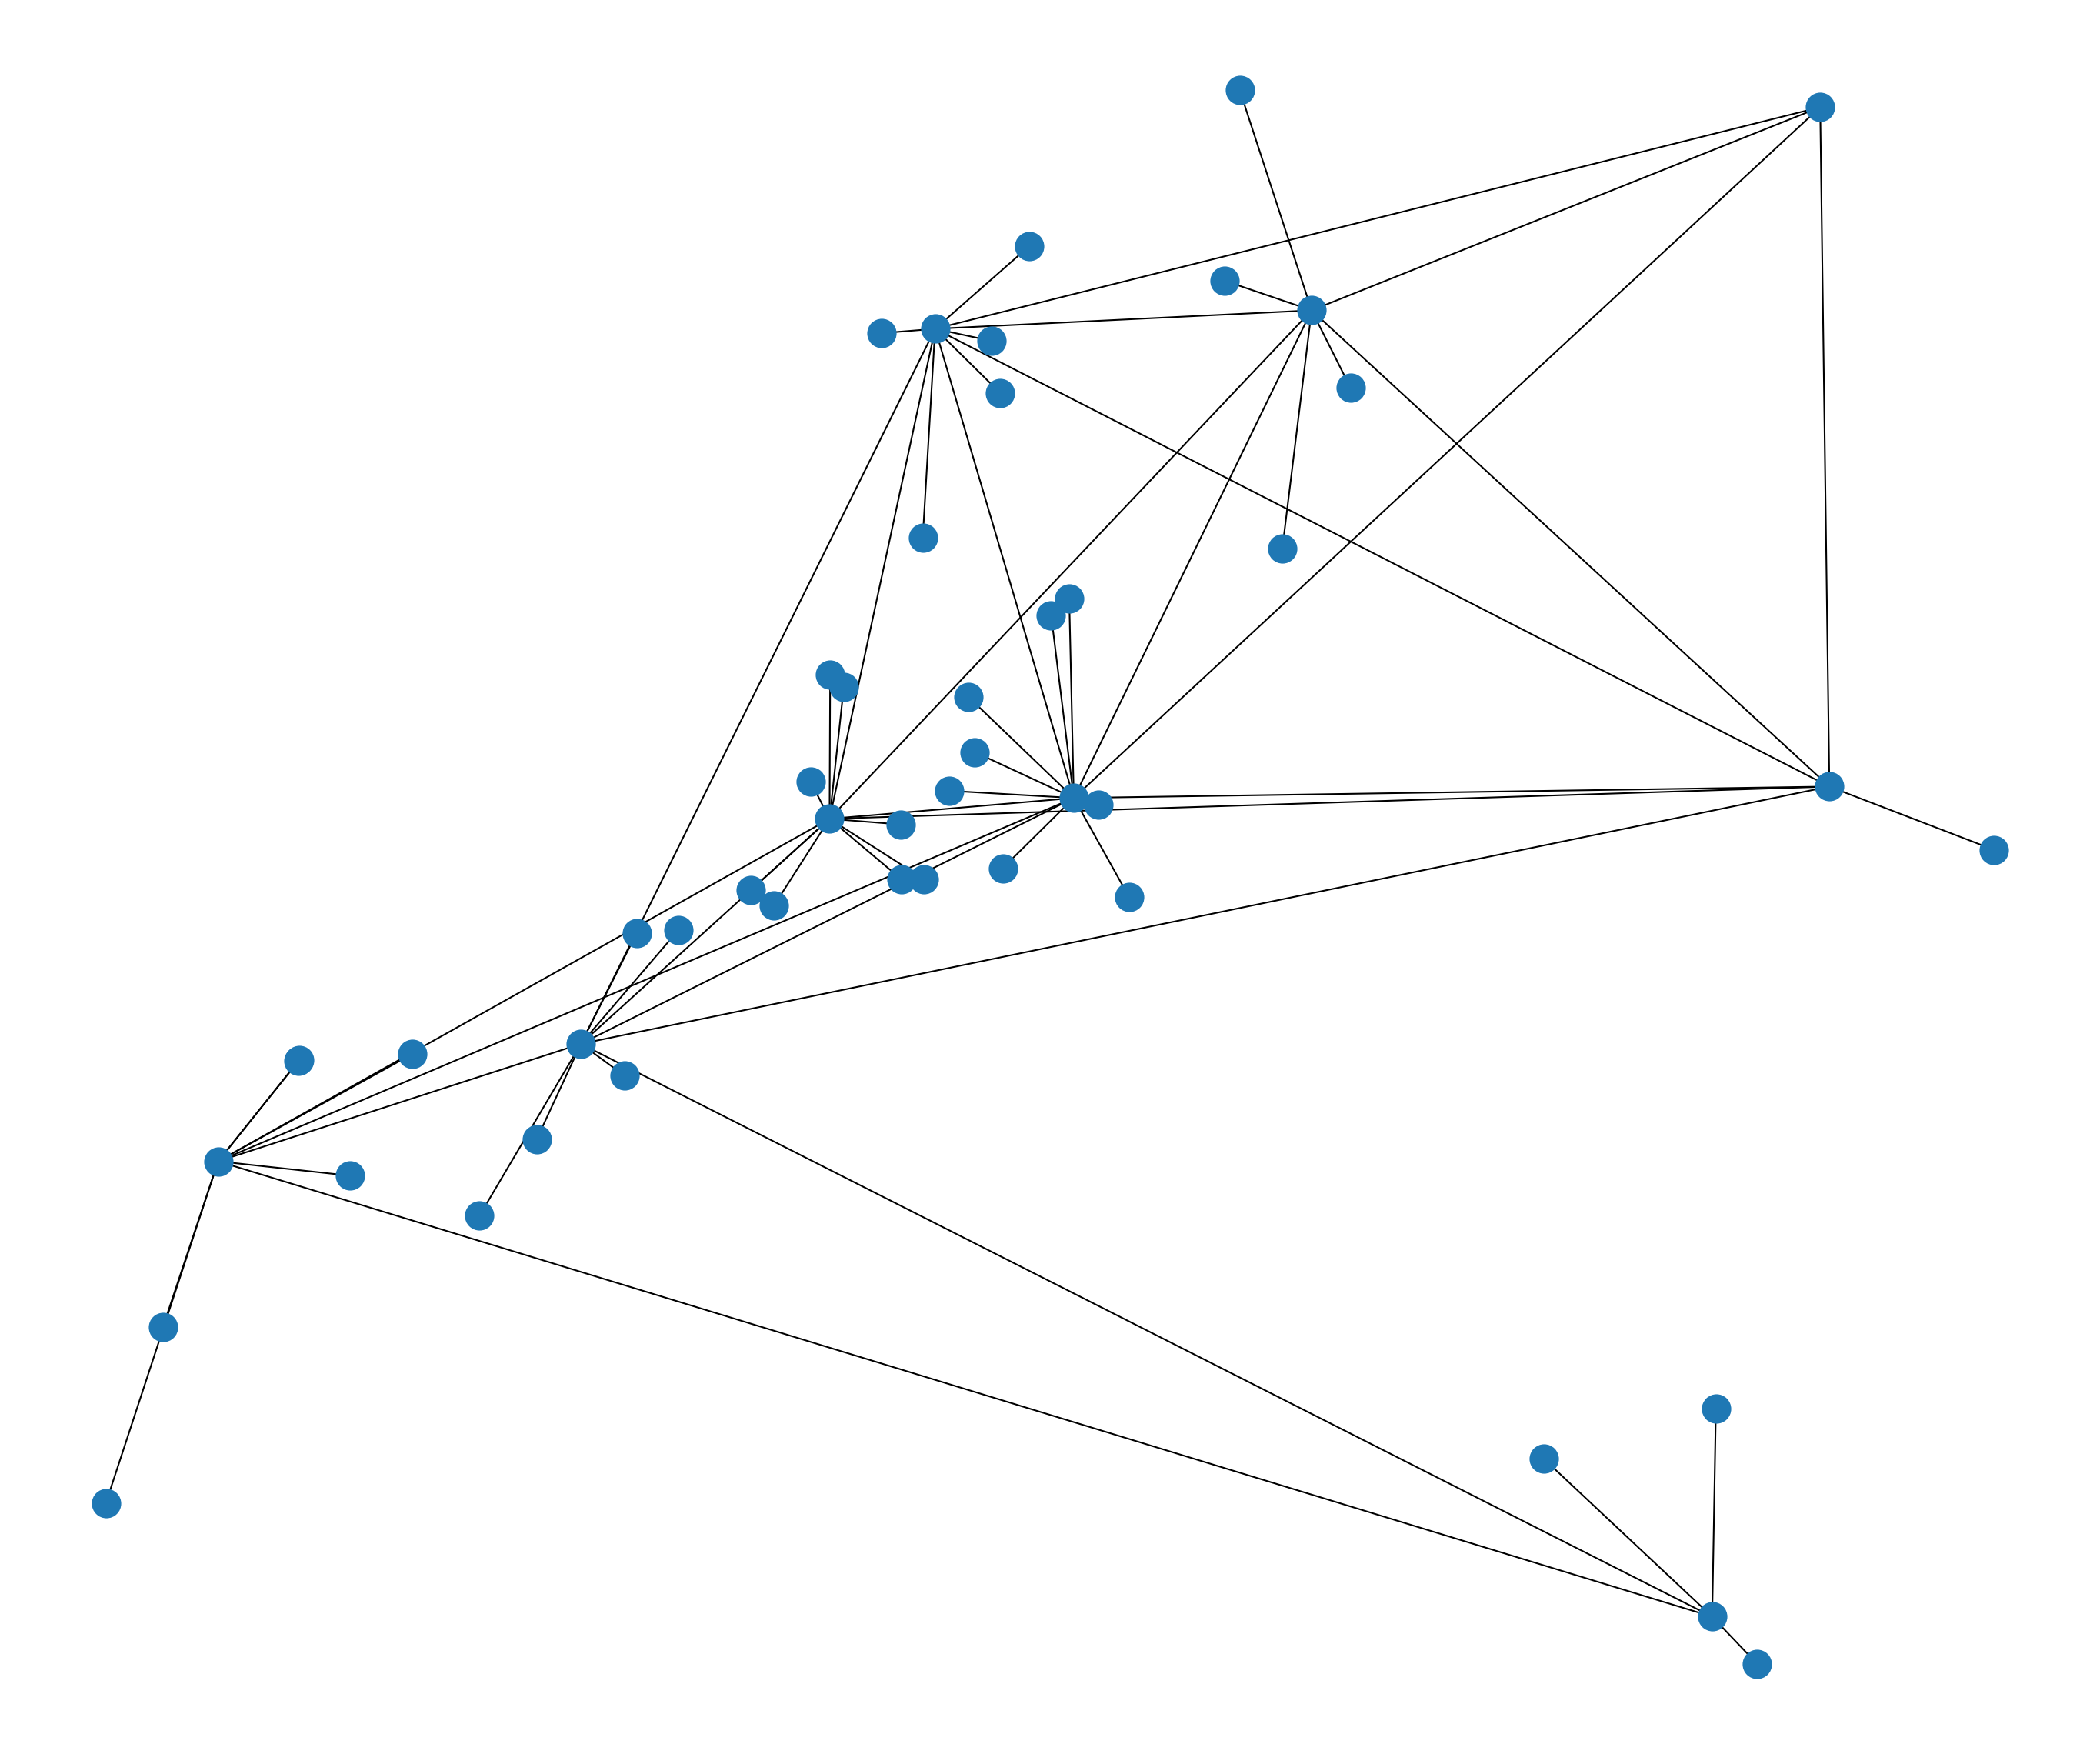

In [22]:
import networkx as nx

G=nx.Graph()
for index, row in df.iterrows():
    G.add_node(row["id"],pos=(row["cartesianas"][0],row["cartesianas"][1]))
    if row["distancia_centro"] !=0 :
        G.add_edge(row["hospitales_centros"],row["id"],weight=row["distancia_centro"])

for index, row in cdf.iterrows():
    if row["distancias"] < maxima_distancia:
        G.add_edge(row["inicio"],row["final"],weight=row["distancias"])

pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
source = 1
target = 1
print(nx.floyd_warshall_numpy(G, nodelist=G.nodes, weight='weight'))
print([p for p in nx.all_shortest_paths(G, source=source, target=target,weight="weight")])
print(nx.shortest_path_length(G, source=source, target=target,weight="weight"))


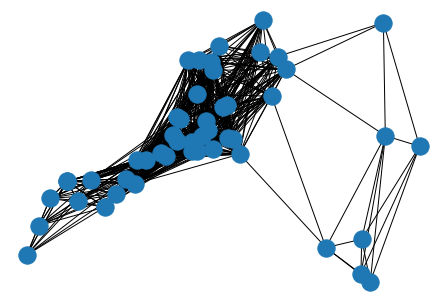

In [36]:
maxima_distancia=4
G2=nx.Graph()
for index, row in df.iterrows():
    G2.add_node(row["id"],pos=(row["cartesianas"][0],row["cartesianas"][1]))
cantidad_de_nodos=len(df["cartesianas"])
for i in range(0,cantidad_de_nodos):
    for j in range(0,cantidad_de_nodos):
        if calcular_distancia_euclidean(df["cartesianas"][i],df["cartesianas"][j])<maxima_distancia and i!=j:
            G2.add_edge(i,j,weight=calcular_distancia_euclidean(df["cartesianas"][i],df["cartesianas"][j]))

pos=nx.get_node_attributes(G2,'pos')
nx.draw(G2,pos)


